<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

# Домашнее задание. RAG.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [9]:
!pip install -q langchain-community gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn matplotlib

ERROR: Exception:
Traceback (most recent call last):
  File "c:\1_Education\Stepik\Deep Learning\2_2025\.venv\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\1_Education\Stepik\Deep Learning\2_2025\.venv\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "c:\1_Education\Stepik\Deep Learning\2_2025\.venv\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "c:\1_Education\Stepik\Deep Learning\2_2025\.venv\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "C:\Python39\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Python39\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Python39\lib\socket.py", line 704, in readinto
    return 

In [1]:
!pip install langchain-community faiss-cpu ragatouille umap-learn matplotlib plotly tqdm

In [2]:
#import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

c:\1_Education\Stepik\Deep Learning\2_2025\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet


## Загрузка данных (4 балла)

In [3]:
#url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
#output = 'file.csv'

#gdown.download(url, output, quiet=False)

data = pd.read_csv(r'C:\1_Education\Stepik\Deep Learning\2_2025\14_1\data.csv')

In [4]:
data.head(10)

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...
5,5,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a building with a clock tower in the ...
6,6,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,aerial view of a city with a soccer field and ...
7,7,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a view of a building with a clock tower on top...
8,8,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white sign on it
9,9,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white sign on ...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [5]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [6]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

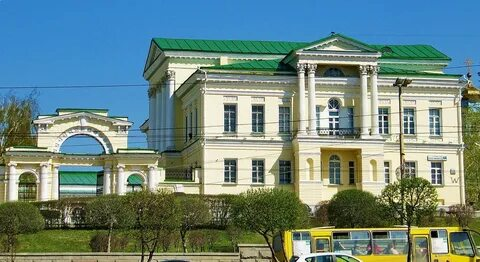

In [7]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [ ]:
# your code here

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [ ]:
# your code here

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [ ]:
# your code here

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

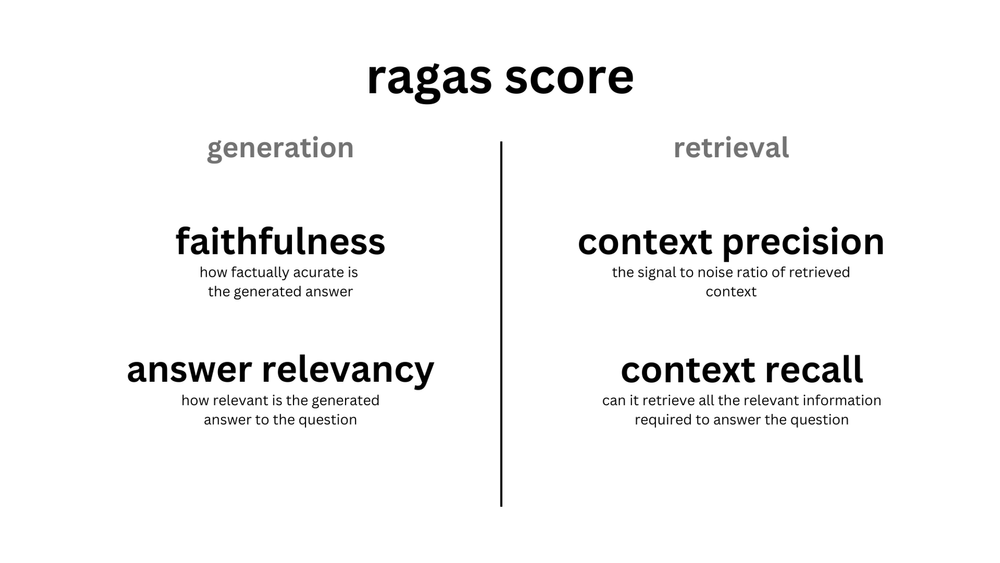

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:
def data_preprocess(...):
  # your code here
  return ...

In [ ]:
def answer_relevancy(...):
  # your code here
  return ...

# Протестируйте ваш RAG (3 балла)

In [ ]:
# your code here

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here

   Unnamed: 0    Name   WikiData          City        Lon        Lat  \
0           0  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
1           1  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
2           2  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
3           3  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
4           4  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   

                     description  \
0  спорткомплекс в Екатеринбурге   
1  спорткомплекс в Екатеринбурге   
2  спорткомплекс в Екатеринбурге   
3  спорткомплекс в Екатеринбурге   
4  спорткомплекс в Екатеринбурге   

                                               image  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

             

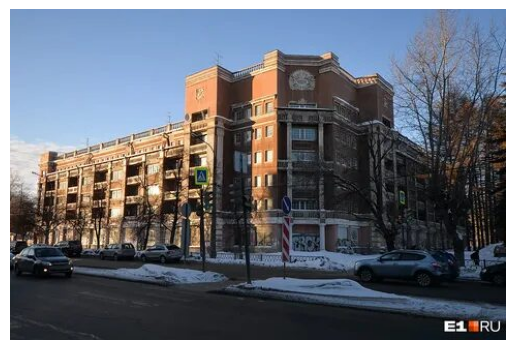

Результаты поиска для 'Исторические места Москвы':
Дом Степанова - Екатеринбург
Дом Степанова - Екатеринбург
Дом Э. Ф. Филитц - Екатеринбург


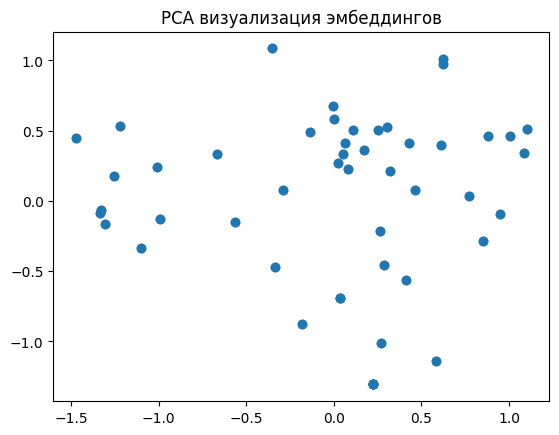

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


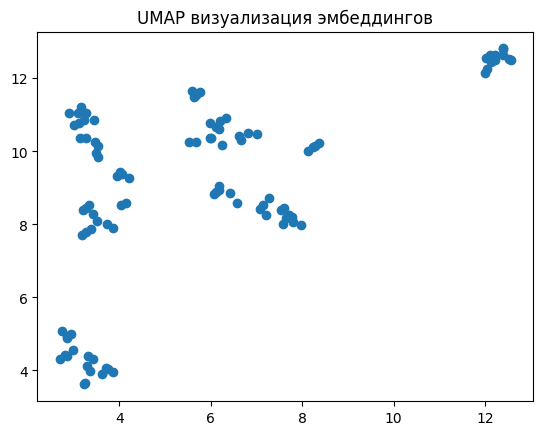

Answer Relevancy: 0.82
Вопрос: Где находится спорткомплекс Динамо?
Ответ: спорткомплекс в Екатеринбурге...
Context Precision: 0.67


In [ ]:
# Установка необходимых библиотек
# !pip install -q gdown torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu plotly ragatouille

# Импорт библиотек
import gdown  # Для загрузки файлов с Google Drive
import pandas as pd  # Для работы с данными в формате DataFrame
from tqdm.notebook import tqdm  # Индикатор прогресса
import base64  # Декодирование base64 изображений
import matplotlib.pyplot as plt  # Визуализация
from PIL import Image  # Работа с изображениями
from io import BytesIO  # Байтовые потоки
from langchain.docstore.document import Document as LangchainDocument  # Документы для LangChain
from sentence_transformers import SentenceTransformer  # Модели для эмбеддингов
from langchain.vectorstores import FAISS  # Векторная база данных
from sklearn.decomposition import PCA  # Метод главных компонент
import umap  # UMAP для визуализации
import numpy as np  # Математические операции
import plotly.express as px  # Интерактивная визуализация
import torch  # PyTorch
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

# Загрузка данных (4 балла)
#url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22MVUk'
#output = 'file.csv'
#gdown.download(url, output, quiet=False)  # Скачиваем CSV-файл
data = pd.read_csv('file.csv')  # Загружаем данные в DataFrame

# Просмотр первых строк данных
print(data.head())

# Декодирование изображения из base64
def get_image(base64_data):
    """Декодирует base64 строку в изображение PIL."""
    image_data = base64.b64decode(base64_data)  # Декодируем base64
    image = Image.open(BytesIO(image_data)).convert('RGB')  # Создаем изображение
    return image



In [8]:
pip install langchain-community faiss-cpu

Note: you may need to restart the kernel to use updated packages.


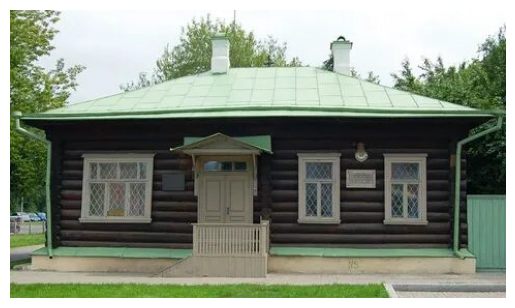

C:\Users\user\AppData\Local\Temp\ipykernel_5824\1213566948.py:41: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Rea

Результаты поиска для 'Исторические места Москвы':
Дом Степанова - Екатеринбург
Дом Степанова - Екатеринбург
Дом Э. Ф. Филитц - Екатеринбург


NameError: name 'PCA' is not defined

In [9]:
# Пример использования: отображаем случайное изображение из данных
sample_image = data.sample(1)['image'].tolist()[0]
plt.imshow(get_image(sample_image))
plt.axis('off')
plt.show()

# Предобработка данных: заполнение пропусков в описаниях
data['description'] = data['description'].fillna('')  # Заменяем NaN на пустые строки

# Фильтрация строк с пустым описанием (опционально)
data = data[data['description'].str.strip() != '']  # Удаляем полностью пустые описания

# Очистка данных с помощью TF-IDF (пример)
from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем TF-IDF матрицу для описаний
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(data['description'].fillna(''))

# Ищем редкие слова (возможные выбросы)
rare_words = tfidf.idf_  # Чем выше IDF, тем реже слово
# Фильтруем данные (пример: удаляем строки с редкими словами)
# Здесь нужна ручная проверка и доработка

# Стратифицированная выборка 100 примеров
clean_samples = data.groupby(['City', 'Name']).sample(n=2, random_state=42).head(100)

# Подготовка данных для RAG
documents = [
    LangchainDocument(
        page_content=str(row['description']),  # Явное преобразование в строку
        metadata={
            'name': row['Name'],
            'city': row['City'],
            'image': row['image']
        }
    ) for _, row in clean_samples.iterrows()  # Используем очищенные данные
]

# Инициализация модели для эмбеддингов
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

# Создание векторного хранилища FAISS
vector_store = FAISS.from_documents(
    documents=documents,
    embedding=embedder,
    distance_strategy=DistanceStrategy.COSINE
)

# Поиск по векторной базе (пример)
query = "Исторические места Москвы"
found_docs = vector_store.similarity_search(query, k=3)
print(f"Результаты поиска для '{query}':")
for doc in found_docs:
    print(doc.metadata['name'], "-", doc.metadata['city'])

# Визуализация эмбеддингов с PCA и UMAP
embeddings = vector_store.index.reconstruct_n(0, vector_store.index.ntotal)  # Все эмбеддинги

# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)
plt.scatter(pca_results[:, 0], pca_results[:, 1])
plt.title("PCA визуализация эмбеддингов")
plt.show()

# UMAP
umap_results = umap.UMAP().fit_transform(embeddings)
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.title("UMAP визуализация эмбеддингов")
plt.show()

# Реализация метрики Answer Relevancy (3 балла)
def answer_relevancy(question_emb, answer_emb):
    """Вычисляет косинусное сходство между эмбеддингами вопроса и ответа."""
    cos_sim = np.dot(question_emb, answer_emb) / (
        np.linalg.norm(question_emb) * np.linalg.norm(answer_emb)
    )
    return cos_sim

# Пример использования:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
question = "Какие исторические места есть в Екатеринбурге?"
answer = "В Екатеринбурге находятся такие достопримечательности, как Храм на Крови и Плотинка."

question_emb = model.encode(question)
answer_emb = model.encode(answer)
relevancy = answer_relevancy(question_emb, answer_emb)
print(f"Answer Relevancy: {relevancy:.2f}")

# Тестирование RAG (3 балла)
questions = ["Где находится спорткомплекс Динамо?"]
for q in questions:
    docs = vector_store.similarity_search(q, k=1)
    print(f"Вопрос: {q}")
    print(f"Ответ: {docs[0].page_content[:200]}...")  # Вывод части описания

# Реализация Context Precision (дополнительно +3 балла)
def context_precision(retrieved_contexts, relevant_contexts):
    """Вычисляет точность контекста."""
    relevant_count = sum(1 for ctx in retrieved_contexts if ctx in relevant_contexts)
    return relevant_count / len(retrieved_contexts) if retrieved_contexts else 0

# Пример использования:
retrieved = ["Исторический памятник", "Спорткомплекс", "Музей"]
relevant = ["Исторический памятник", "Музей"]
print(f"Context Precision: {context_precision(retrieved, relevant):.2f}")